<a href="https://colab.research.google.com/github/ravi-ai-cons/smart_compose_sentence_completion/blob/master/Copy_of_Smart_Compose_Sentence_Completion_0217.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import library packages
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, CuDNNLSTM, Dropout, Bidirectional, Concatenate
import pandas as pd
import numpy as np
import json

tf.__version__

'1.15.0'

In [0]:
# Connect Colab to Google Drive 
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Enron https://data.world/brianray/enron-email-dataset 
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/enron_05_17_2015_with_labels_v2.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,15,44,47,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
len(data)

517401

In [0]:
# Consider emails with limited words and that are Non-replies
sample_data = data[(data['content'].str.len() < 100) & ~(data['subject'].str.contains('Re:', na=False))]

In [0]:
len(sample_data)

34998

In [0]:
corpus = sample_data['content']
# corpus = data['content']

In [0]:
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, '')
    return text

def preprocess(data):
    output = []
    punct = '#$%&*+-/<=>[\\]@^_`{|}~\t\n'
    for line in data:
         pline = clean_special_chars(str(line).lower(), punct)
         output.append(pline)
    return output  

def generate_dataset():
    processed_corpus = preprocess(corpus)    
    output = []
    for line in processed_corpus:
        for i in range(1, len(line)):
            data = []
            x_ngram = '<start> '+ line[:i+1] + ' <end>'
            y_ngram = '<start> '+ line[i+1:] + ' <end>'
            data.append(x_ngram)
            data.append(y_ngram)
            output.append(data)
    print("Dataset prepared with prefix and suffixes for RNN as part of teacher forcing technique")
    # print(pd.DataFrame(output, columns=['input', 'output']).iloc[65:80])
    return output

In [0]:
class ComposeIndex():
    def __init__(self, phrase):
        self.phrase = phrase
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for sub_phrase in self.phrase:
            self.vocab.update(sub_phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset():
    pairs = generate_dataset()
    in_phrase = ComposeIndex(x_ngram for x_ngram, y_ngram in pairs)
    out_phrase = ComposeIndex(y_ngram for x_ngram, y_ngram in pairs)
    input_data = [[in_phrase.word2idx[s] for s in x_ngram.split(' ')] for x_ngram, y_ngram in pairs]
    output_data = [[out_phrase.word2idx[s] for s in y_ngram.split(' ')] for x_ngram, y_ngram in pairs]

    # print(input_data[:20])
    # print(in_phrase.phrase)
    # print(in_phrase.word2idx)
    # print(in_phrase.idx2word)
    # print(in_phrase.vocab)

    max_length_in = max_length(input_data)
    max_length_out = max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_phrase, out_phrase, max_length_in, max_length_out

In [0]:
# load_dataset()
input_data, teacher_data, input_phrase, target_phrase, len_input, len_target = load_dataset()

Dataset prepared with prefix and suffixes for RNN as part of teacher forcing technique


In [0]:
target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.
p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

In [0]:
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_phrase.word2idx)
vocab_out_size = len(target_phrase.word2idx)

In [0]:
# Creating the Encoder layers.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Bidirectional LSTM
encoder_lstm = Bidirectional(CuDNNLSTM(units=units, return_sequences=True, return_state=True))
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h, bstate_h])
state_c = Concatenate()([fstate_c, bstate_c])
encoder_states = [state_h, state_c]

# Creating the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers are added to model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))

# Training model that combines the encoder and the decoder.
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_out)

# Using 'sparse_categorical_crossentropy' expanding 'decoder_out' into a massive one-hot array is not required.
model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (Non

In [0]:
epochs = 2
history = model.fit([input_data, teacher_data], target_data,
                    batch_size=BATCH_SIZE, epochs=epochs, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1472148 samples, validate on 368038 samples
Epoch 1/2
 801536/1472148 [===============>..............] - ETA: 37:34 - loss: 1.1762 - sparse_categorical_accuracy: 0.8295

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/smart_compose_model_200217_3.sav', overwrite=False, include_optimizer=True, save_format=None, signatures=None)


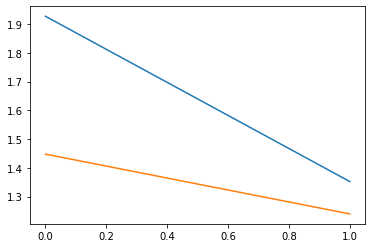

In [0]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [0]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).
inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))

inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [0]:
encoder_model.save_weights("/content/drive/My Drive/Colab Notebooks/smart_compose_enc_model_200217_1.h5")
inf_model.save_weights("/content/drive/My Drive/Colab Notebooks/smart_compose_inf_model_200217_3.h5")

encoder_model_json = encoder_model.to_json()
inference_model_json = inf_model.to_json()

with open("/content/drive/My Drive/Colab Notebooks/smart_compose_enc_model_200217_3.json", "w") as json_file:
    json.dump(json.loads(encoder_model_json), json_file, indent=4)
with open("/content/drive/My Drive/Colab Notebooks/smart_compose_inf_model_200217_3.json", "w") as json_file:
    json.dump(json.loads(inference_model_json), json_file, indent=4)
